# Preliminaries

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn.metrics import classification_report
import scipy.special

PATH_DATA = Path().resolve() / 'data' / 'processed'
PATH_DATA.mkdir(exist_ok=True)

df_train_olid_small = pd.read_csv(PATH_DATA / 'olid-train-small.csv')
df_train_hasoc = pd.read_csv(PATH_DATA / 'hasoc-train.csv')
df_test_olid = pd.read_csv(PATH_DATA / 'olid-test.csv')

df_test_olid = df_test_olid.sort_values('id').set_index('id')
df_train_hasoc = df_train_hasoc.sort_values('id').set_index('id')
df_train_olid_small = df_train_olid_small.sort_values('id').set_index('id')

In [2]:
df_result = {'ensemble': {}, 'base': {}}
df_result['ensemble']['in_domain'] = pd.read_csv('model_outputs/ensemble/in_domain.csv', header=[0, 1, 2])
df_result['ensemble']['cross_domain'] = pd.read_csv('model_outputs/ensemble/cross_domain.csv', header=[0, 1, 2])
df_result['base']['in_domain'] = pd.read_csv('model_outputs/trained/in_domain.csv', header=[0, 1, 2])
df_result['base']['cross_domain'] = pd.read_csv('model_outputs/trained/cross_domain.csv', header=[0, 1, 2])

for item in ['ensemble', 'base']:
    for setting in ['in_domain', 'cross_domain']:
        df = df_result[item][setting]
        new_col = []
        new_col.append('id')
        for col in df.columns[1:]:
            value_name, model, _ = col
            new_col.append(model + '.' + value_name)
        
        df.columns = new_col
        df_result[item][setting] = df

In [3]:
real = df_test_olid['labels'].values

In [4]:
_REQUIRED_KEYS = [
    ## Classification report metrics
    '0', 
    '1',
    'accuracy',
    'macro avg', 
    'weighted avg',
    ## Raw predictions for later usage
    'predictions',
    ## Raw probability outputs for later usage
    'probabilities'
]

results = None

def validate_results(model, setting):
    for key in _REQUIRED_KEYS:
        assert key in results[setting][model], "INVALID_RESULTS"

def add_result(model, setting, classification_report, predictions, probabilities):
    results[setting][model] = classification_report
    results[setting][model]['predictions'] = predictions
    results[setting][model]['probabilities'] = probabilities
    validate_results(model, setting)

def reset_results():
    global results
    
    results = {
        'in_domain': {

        },
        'cross_domain': {

        }
    }

reset_results()

In [5]:
def process_result(type_, model_name, model_name_clean, setting):
    try:
        probabilities = df_result[type_][setting][model_name + '.probabilities'].values
    except KeyError:
        probabilities = None
    
    add_result(
        model=model_name_clean,
        setting=setting,
        classification_report=classification_report(
            y_true=real,
            y_pred=df_result[type_][setting][model_name + '.predicted'].values,
            output_dict=True
        ),
        predictions=df_result[type_][setting][model_name + '.predicted'].values.ravel(),
        probabilities=probabilities
    )

    print(classification_report(
        y_true=real,
        y_pred=results[setting][model_name_clean]['predictions']
    ))

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def cf_plot(predictions, real, model, setting, ax=None, **kwargs):
    cf_matrix = confusion_matrix(real, predictions)
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    
    params = {
        'annot': labels,
        'fmt': '',
        'cmap': 'Blues',
        **kwargs
    }
    if ax:
        params['ax'] = ax
    
    fig = sns.heatmap(cf_matrix, **params)
        
    fig.set_title(f'{model}\n\n')
    fig.set_xlabel('\nPredicted Values')
    fig.set_ylabel('Actual Values ')

    ## Ticket labels - List must be in alphabetical order
    fig.xaxis.set_ticklabels(['0','1'])
    fig.yaxis.set_ticklabels(['0','1'])

In [7]:
def results_latex(df_results):
    df_results.columns = [col.title() for col in df_results.columns]
    base = df_results.round(4).to_latex(index=False)
    lines = base.split('\n')
    ##  Debugging
    # for i, line in enumerate(base.split('\n')):
    #     print(i, line)
    
    lines[2] = lines[2].replace('Model', '')
    lines.insert(4, r"""\textbf{Base Models} & & & \\""")
    lines.insert(8, r"""\textbf{Ensemble Approaches} & & & \\""")
    print('\n'.join(lines))

# Base Models

## HateBERT

### In-Domain

In [8]:
process_result('base', 'GroNLP/hateBERT', 'HateBERT', 'in_domain')

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       620
           1       0.73      0.74      0.74       240

    accuracy                           0.85       860
   macro avg       0.82      0.82      0.82       860
weighted avg       0.85      0.85      0.85       860



### Cross-Domain

In [9]:
process_result('base', 'GroNLP/hateBERT', 'HateBERT', 'cross_domain')

              precision    recall  f1-score   support

           0       0.82      0.94      0.87       620
           1       0.74      0.45      0.56       240

    accuracy                           0.80       860
   macro avg       0.78      0.69      0.72       860
weighted avg       0.79      0.80      0.79       860



## fBERT

### In-Domain

In [10]:
process_result('base', 'diptanu/fBERT', 'fBERT', 'in_domain')

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       620
           1       0.75      0.73      0.74       240

    accuracy                           0.86       860
   macro avg       0.82      0.82      0.82       860
weighted avg       0.86      0.86      0.86       860



### Cross-Domain

In [11]:
process_result('base', 'diptanu/fBERT', 'fBERT', 'cross_domain')

              precision    recall  f1-score   support

           0       0.85      0.95      0.90       620
           1       0.82      0.58      0.68       240

    accuracy                           0.85       860
   macro avg       0.84      0.77      0.79       860
weighted avg       0.84      0.85      0.84       860



## BERT

### In-Domain

In [12]:
process_result('base', 'bert-base-uncased', 'BERT', 'in_domain')

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       620
           1       0.76      0.72      0.74       240

    accuracy                           0.86       860
   macro avg       0.82      0.82      0.82       860
weighted avg       0.86      0.86      0.86       860



### Cross-Domain

In [13]:
process_result('base', 'bert-base-uncased', 'BERT', 'cross_domain')

              precision    recall  f1-score   support

           0       0.85      0.94      0.89       620
           1       0.77      0.56      0.65       240

    accuracy                           0.83       860
   macro avg       0.81      0.75      0.77       860
weighted avg       0.83      0.83      0.82       860



# Ensemble Approaches

## Hard Majority

### In-Domain

In [14]:
process_result('ensemble', 'hard', 'Hard Majority Ensemble', 'in_domain')

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       620
           1       0.76      0.75      0.75       240

    accuracy                           0.86       860
   macro avg       0.83      0.83      0.83       860
weighted avg       0.86      0.86      0.86       860



### Cross-Domain

In [15]:
process_result('ensemble', 'hard', 'Hard Majority Ensemble', 'cross_domain')

              precision    recall  f1-score   support

           0       0.85      0.95      0.90       620
           1       0.82      0.55      0.66       240

    accuracy                           0.84       860
   macro avg       0.84      0.75      0.78       860
weighted avg       0.84      0.84      0.83       860



## Soft Majority

### In-Domain

In [16]:
process_result('ensemble', 'soft', 'Soft Majority Ensemble', 'in_domain')

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       620
           1       0.77      0.74      0.75       240

    accuracy                           0.87       860
   macro avg       0.83      0.83      0.83       860
weighted avg       0.86      0.87      0.86       860



### Cross-Domain

In [17]:
process_result('ensemble', 'soft', 'Soft Majority Ensemble', 'cross_domain')

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       620
           1       0.81      0.53      0.64       240

    accuracy                           0.83       860
   macro avg       0.83      0.74      0.77       860
weighted avg       0.83      0.83      0.82       860



## Meta Model

### In-Domain

In [18]:
process_result('ensemble', 'meta', 'Meta Model', 'in_domain')

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       620
           1       0.77      0.67      0.72       240

    accuracy                           0.85       860
   macro avg       0.82      0.80      0.81       860
weighted avg       0.85      0.85      0.85       860



### Cross-Domain

In [19]:
process_result('ensemble', 'meta', 'Meta Model', 'cross_domain')

              precision    recall  f1-score   support

           0       0.84      0.94      0.89       620
           1       0.77      0.53      0.63       240

    accuracy                           0.83       860
   macro avg       0.81      0.73      0.76       860
weighted avg       0.82      0.83      0.81       860



# Overall

## In Classification Metrics

In [20]:
df_results = []
for model in results['in_domain'].keys():
    df_results.append({
        'Model': model,
        **results['in_domain'][model]['macro avg']
    })
df_results = pd.DataFrame(df_results)
df_results = df_results[df_results.columns[:-1]]
df_results.round(4)

,Model,precision,recall,f1-score
0,HateBERT,0.8160,0.8184,0.8172
1,fBERT,0.8216,0.8183,0.8199
2,BERT,0.8246,0.8153,0.8197
3,Hard Majority Ensemble,0.8321,0.8278,0.8299
4,Soft Majority Ensemble,0.8343,0.8273,0.8306
5,Meta Model,0.8226,0.7959,0.8074


In [21]:
results_latex(df_results)

\begin{tabular}{lrrr}
\toprule
                  &  Precision &  Recall &  F1-Score \\
\midrule
\textbf{Base Models} & & & \\
              HateBERT &     0.8160 &  0.8184 &    0.8172 \\
                 fBERT &     0.8216 &  0.8183 &    0.8199 \\
                  BERT &     0.8246 &  0.8153 &    0.8197 \\
\textbf{Ensemble Approaches} & & & \\
Hard Majority Ensemble &     0.8321 &  0.8278 &    0.8299 \\
Soft Majority Ensemble &     0.8343 &  0.8273 &    0.8306 \\
            Meta Model &     0.8226 &  0.7959 &    0.8074 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_17217/1397639413.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  base = df_results.round(4).to_latex(index=False)


## Cross Domain Classification Metrics

In [22]:
df_results = []
for model in results['cross_domain'].keys():
    df_results.append({
        'Model': model,
        **results['cross_domain'][model]['macro avg']
    })
df_results = pd.DataFrame(df_results)
df_results = df_results[df_results.columns[:-1]]
df_results.round(4)

,Model,precision,recall,f1-score
0,HateBERT,0.7774,0.6944,0.7161
1,fBERT,0.8368,0.7667,0.7906
2,BERT,0.8101,0.7477,0.7690
3,Hard Majority Ensemble,0.8354,0.7524,0.7785
4,Soft Majority Ensemble,0.8268,0.7412,0.7671
5,Meta Model,0.8060,0.7347,0.7574


In [23]:
results_latex(df_results)

\begin{tabular}{lrrr}
\toprule
                  &  Precision &  Recall &  F1-Score \\
\midrule
\textbf{Base Models} & & & \\
              HateBERT &     0.7774 &  0.6944 &    0.7161 \\
                 fBERT &     0.8368 &  0.7667 &    0.7906 \\
                  BERT &     0.8101 &  0.7477 &    0.7690 \\
\textbf{Ensemble Approaches} & & & \\
Hard Majority Ensemble &     0.8354 &  0.7524 &    0.7785 \\
Soft Majority Ensemble &     0.8268 &  0.7412 &    0.7671 \\
            Meta Model &     0.8060 &  0.7347 &    0.7574 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_17217/1397639413.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  base = df_results.round(4).to_latex(index=False)


## In-Domain Confusion Matrices

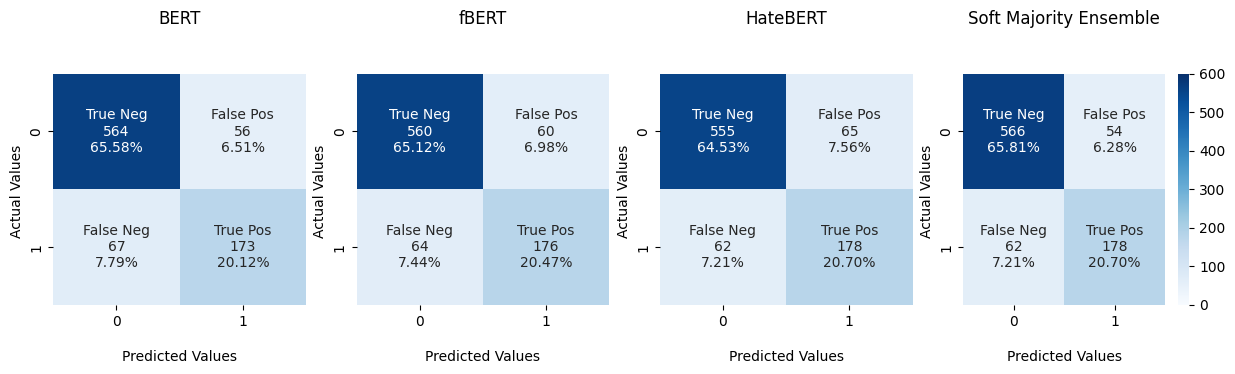

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 3))

for i, model_name in enumerate(['BERT', 'fBERT', 'HateBERT', 'Soft Majority Ensemble']):
    cbar = False if i < 3 else True
    
    cf_plot(
        predictions=results['in_domain'][model_name]['predictions'],
        real=real,
        ax=axs[i],
        cbar=cbar,
        model=model_name,
        setting='In-Domain',
        vmin=0,
        vmax=600,
    )

plt.savefig('in_domain_confusion_matrix.svg')

## Cross-Domain Confusion Matrices

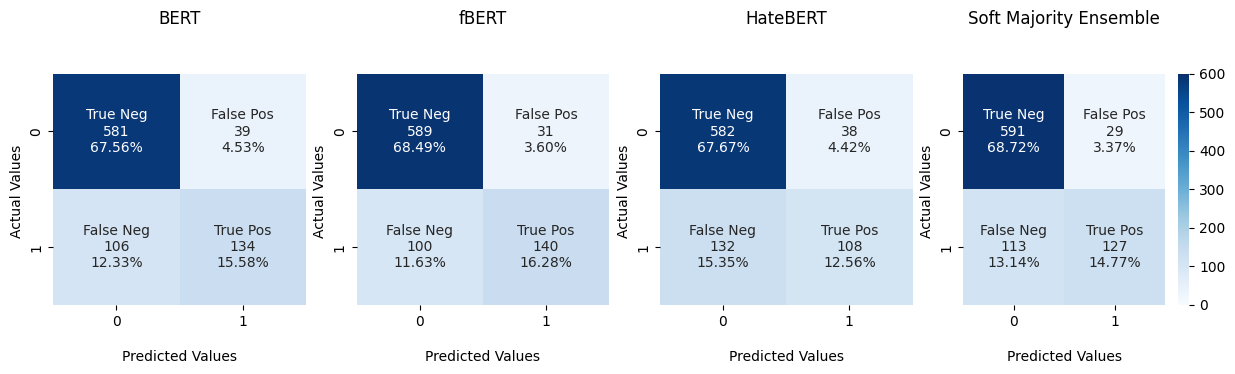

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 3))

for i, model_name in enumerate(['BERT', 'fBERT', 'HateBERT', 'Soft Majority Ensemble']):
    cbar = False if i < 3 else True
    
    cf_plot(
        predictions=results['cross_domain'][model_name]['predictions'],
        real=real,
        ax=axs[i],
        cbar=cbar,
        model=model_name,
        setting='In-Domain',
        vmin=0,
        vmax=600,
    )

plt.savefig('cross_domain_confusion_matrix.svg')

# Qualitative Error Analysis

Done via Excel / GSheets

## In-Domain

In [30]:
error_analysis_in_domain = pd.read_csv('data/raw/olid-test.csv')
error_analysis_in_domain = error_analysis_in_domain.sort_values('id')
error_analysis_in_domain['prediction'] = results['in_domain']['Soft Majority Ensemble']['predictions']
error_analysis_in_domain['P(hate)'] = results['in_domain']['Soft Majority Ensemble']['probabilities']
error_analysis_in_domain.to_csv('data/in_domain_analysis.csv', index=False)

## Cross-Domain

In [31]:
error_analysis_cross_domain = pd.read_csv('data/raw/olid-test.csv')
error_analysis_cross_domain = error_analysis_cross_domain.sort_values('id')
error_analysis_cross_domain['prediction'] = results['cross_domain']['Soft Majority Ensemble']['predictions']
error_analysis_cross_domain['P(hate)'] = results['cross_domain']['Soft Majority Ensemble']['probabilities']
error_analysis_cross_domain.to_csv('data/cross_domain_analysis.csv', index=False)

In [32]:
dff = error_analysis_cross_domain

In [33]:
dff = dff[dff['labels'] == 1]
dff = dff[dff['prediction'] == 0]
for i, row in dff.sort_values('P(hate)').head(20).iterrows():
    print(row['P(hate)'])
    print(row['text'])

0.1838751163069062
#BREAKING. #Greece: Molotov cocktails fly after protest honouring killed antifa arti... URL via @USER URL
0.1861054915732508
#NoPasaran: Unity demo to oppose the far-right in #London – #antifa #Oct13 — Enough is Enough! URL
0.1971220693615422
#GreatestThingsAboutThe90s liberals weren’t unhinged
0.2014037907775795
#Liberals Are Reaching Peak Desperation To Call On #PhillipRuddock To Talk With #Turnbull To Convince Him To Help with #WentworthVotes 18 Sept 2018  @USER #Auspol #LNP #NSWpol @USER  @USER @USER #LNPMemes URL
0.2158347987588683
#Conservatives Govt have run up debt in spite of austerity cuts while the rich have doubled their wealth. #inequality  URL via @USER
0.2228060571444725
#EmmyAwards2018 - Ratings tank as expected.  Who can possibly stand to watch so many liberals in one place at one time.
0.2291610909461995
@USER Antifa has TS level influence. It's scary.
0.2297271107557907
#CarbonTax works and will put tons more money BACK INTO Canadian pockets.  .@US